In [115]:
import json
import logging
from sqlalchemy import Column, Integer, String, Float, DateTime, Boolean, func
from iotfunctions import bif
#import sklearn.external.joblib as extjoblib
import joblib


from iotfunctions.metadata import EntityType
from iotfunctions.db import Database
from iotfunctions.base import BaseTransformer
from iotfunctions.bif import EntityDataGenerator

import datetime as dt
from datetime import datetime

import pandas as pd
import numpy as np

#from watson_machine_learning_client import WatsonMachineLearningAPIClient
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.pipeline import Pipeline
import sklearn


In [116]:
# set Monitor credentials here and entity type
credentials = {}
with open('credentials_as_beta2.json', encoding='utf-8') as F:
    credentials = json.loads(F.read())
db = Database(credentials = credentials)
#db_schema = "public" #  set if you are not using the default
db_schema = "BLUADMIN" #  set if you are not using the default
entity_type = 'AlarmData_Type'

2021-08-26T19:40:53.666 DEBUG iotfunctions.db.__init__ file name db => /home/markus/src/mmfunctions/db2_certificate.pem
2021-08-26T19:40:53.668 DEBUG iotfunctions.db.__init__ created a CosClient object
2021-08-26T19:40:53.673 DEBUG iotfunctions.db.__init__ Set isolation
2021-08-26T19:40:55.909 DEBUG iotfunctions.db.__init__ Isolation level set
2021-08-26T19:40:55.910 DEBUG iotfunctions.db.__init__ Database connection via SqlAlchemy established.
2021-08-26T19:40:57.161 DEBUG iotfunctions.db.__init__ Native database connection to DB2 established.
2021-08-26T19:40:57.163 DEBUG iotfunctions.db.http_request URL: https://api-beta.connectedproducts.internetofthings.ibmcloud.com/api/meta/v1/beta-2/entityType
2021-08-26T19:40:57.166 DEBUG urllib3.connectionpool._new_conn Starting new HTTPS connection (1): api-beta.connectedproducts.internetofthings.ibmcloud.com:443
2021-08-26T19:40:58.161 DEBUG urllib3.connectionpool._make_request https://api-beta.connectedproducts.internetofthings.ibmcloud.com

In [5]:
#Read original pin data
table_name= "IOT_AlarmData_Type"
df = db.read_table(table_name=table_name, schema=db_schema)
print(df.describe())

/home/markus/.local/lib/python3.9/site-packages/sqlalchemy/engine/reflection.py:941: SAWarning: index key 'sqlnotapplicable' was not located in columns for table 'IOT_ALARMDATA_TYPE'
  util.warn(


            alarmid      priority         etype         VALUE
count  7.450100e+04  74501.000000  74501.000000  74501.000000
mean   7.295567e+06      1.386760      0.938833     14.408644
std    2.200029e+04      1.373107      0.737984    118.667890
min    7.257690e+06      0.000000      0.000000   -281.000000
25%    7.276600e+06      0.000000      0.000000      0.000000
50%    7.295251e+06      1.000000      1.000000      0.000000
75%    7.314750e+06      3.000000      1.000000      0.000000
max    7.333733e+06      4.000000      2.000000   7786.448730


In [6]:
# "Drop Duplicates")
print(df.info)
df.drop_duplicates()
print(df.info)

<bound method DataFrame.info of        alarmid                               eventid  \
0      7325462  e9c7eb4a-1abc-46cf-9752-ee86d75fc868   
1      7325463  e3a8cb10-557c-4f13-b246-7a8c99e83cf5   
2      7325464  2a565879-a209-4ab1-9554-e89f7b34f5bc   
3      7325465  2a565879-a209-4ab1-9554-e89f7b34f5bc   
4      7325466  9e80e81a-05ec-41ab-a4c2-691d397993c3   
...        ...                                   ...   
74496  7325457  e9c7eb4a-1abc-46cf-9752-ee86d75fc868   
74497  7325458  842c4fa2-a12b-432f-96cb-6e797dde0cf5   
74498  7325459  eb361fd7-4242-4a02-baa1-04276979187d   
74499  7325460  5e7dfcb7-c5b8-4ed6-80c6-2b15b3f278d9   
74500  7325461  5e7dfcb7-c5b8-4ed6-80c6-2b15b3f278d9   

                                             displaypath  priority  etype  \
0        CA1 HVAC - VVT-T109 Room Temp. - Below Setpoint         2      1   
1         CA5 HVAC - AC-3 Supply Temp.  - Below Setpoint         0      2   
2         CA5 HVAC - AC-3 Supply Temp.  - Below Setpoint        

In [7]:
print(df['rcv_timestamp_utc'])

0       2021-08-12 01:06:10
1       2021-08-12 01:18:43
2       2021-08-12 01:18:43
3       2021-08-12 01:20:37
4       2021-08-12 01:22:03
                ...        
74496   2021-08-12 00:38:54
74497   2021-08-12 00:48:03
74498   2021-08-12 00:51:28
74499   2021-08-12 00:51:28
74500   2021-08-12 00:53:21
Name: rcv_timestamp_utc, Length: 74501, dtype: datetime64[ns]


In [8]:
# Only run when you needed to export data to another Monitor Tenant
#df['rcv_timestamp_utc'].apply(lambda x: x.strftime('%Y-%m-%d %H:%M:%S.%f')[:-3])
# df['updated_utc'].apply(lambda x: x.strftime('%Y-%m-%d %H:%M:%S.%f')[:-3])
df.to_csv('AlarmData_Type.csv')

In [9]:
#Read alarm dimension data
table_name= "IOT_AlarmData_Type_CTG"
df_dm = db.read_table(table_name=table_name, schema=db_schema)
print(df_dm.describe())

                                    deviceid level_0 level_1 level_2  \
count                                  10464   10464   10461   10456   
unique                                 10464      16      43     526   
top     32eec630-c2c7-3f5f-9f0c-0ee4b4baec8d     ca3     mxl    acms   
freq                                       1    5096    7055    3181   

                                   tagpath level_3 level_4       client  \
count                                10464   10164    9391        10464   
unique                               10464    1206     903            1   
top     ca3e/mxl/gacp/loop009/loop009_11/9    acm1  faults  LAMResearch   
freq                                     1    1280     276        10464   

       level_5  level_6  
count     4947     3672  
unique     271       33  
top      fault  loalarm  
freq       235     1595  


In [10]:
# "Drop Duplicates")
print(df_dm.info)
df_dm.drop_duplicates()
print(df_dm.info)

<bound method DataFrame.info of                                    deviceid level_0 level_1  \
0      b75fe3cb-72dc-346d-bf6c-8e8beb7c4975     ca3     mxl   
1      bf623d3a-44f1-35e5-9279-18e970ee9e32     ca3    hvac   
2      c9bc3e3e-ca31-35e8-bc06-6facdd062abb     ca3     mxl   
3      c88e939a-d5c7-3b46-98aa-d78762267355     ca4    hvac   
4      ab218acd-c29b-3a21-91ad-8e95abf15466     ca3     pcw   
...                                     ...     ...     ...   
10459  3c29befb-a2fe-3014-a264-934d9fa771ba    ca3e     mxl   
10460  af2ba3f5-d863-3959-836d-1f8dd0e102f8    ca3e     mxl   
10461  095b6468-c055-3056-8075-fdd15ca8cc6f    ca3e     mxl   
10462  443b11ad-c3b3-39c8-937c-a2167a0da64a     ca3    hvac   
10463  6ac97111-1b05-39e5-840d-f7388922f056    ca3e     mxl   

                 level_2                                            tagpath  \
0                   acms               ca3/mxl/acms/acm2/port6/gas4/hialarm   
1                     ac      ca3/hvac/ac/crac2/alarm

In [11]:
# Save Alarm Dimension Data.
df_dm.to_csv('IOT_AlarmData_Type_CTG.csv')

In [12]:
# Select rows with device id 0011f519-de39-35c6-95a3-ba37a9ab7abe
df_rows = df.loc[df['deviceid'] == '0011f519-de39-35c6-95a3-ba37a9ab7abe']
df_rows.info()
df_dm_rows = df_dm.loc[df_dm['deviceid'] == '0011f519-de39-35c6-95a3-ba37a9ab7abe']
df_dm_rows.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 52313 to 57531
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   alarmid              2 non-null      int64         
 1   eventid              2 non-null      object        
 2   displaypath          2 non-null      object        
 3   priority             2 non-null      int64         
 4   etype                2 non-null      int64         
 5   name                 2 non-null      object        
 6   ackby                2 non-null      object        
 7   VALUE                2 non-null      float64       
 8   devicetype           2 non-null      object        
 9   deviceid             2 non-null      object        
 10  logicalinterface_id  2 non-null      object        
 11  eventtype            2 non-null      object        
 12  format               2 non-null      object        
 13  rcv_timestamp_utc    2 non-null

In [13]:
df_dm_rows.head()

,deviceid,level_0,level_1,level_2,tagpath,level_3,level_4,client,level_5,level_6
8006,0011f519-de39-35c6-95a3-ba37a9ab7abe,ca3,mxl,acms,ca3/mxl/acms/acm2/port34/gas9/loalarm,acm2,port34,LAMResearch,gas9,loalarm


In [117]:
# Start here when you have existing data on local drive
import json
import logging
from sqlalchemy import Column, Integer, String, Float, DateTime, Boolean, func
from iotfunctions import bif
#import sklearn.external.joblib as extjoblib
import joblib

# Debugging
from iotfunctions.enginelog import EngineLogging
EngineLogging.configure_console_logging(logging.DEBUG)


from iotfunctions.metadata import EntityType
from iotfunctions.db import Database
from iotfunctions.base import BaseTransformer
from iotfunctions.bif import EntityDataGenerator

import datetime as dt
from datetime import datetime

import pandas as pd
import numpy as np

#from watson_machine_learning_client import WatsonMachineLearningAPIClient
import pandas as pd
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.pipeline import Pipeline
import sklearn

2021-08-26T19:41:10.822 DEBUG iotfunctions.enginelog.configure_console_logging Console logging has been configured. Level = 10


In [127]:
# Read Alarm Dimension Data.
df = pd.read_csv('AlarmData_Type.csv', index_col=0)
df_dm = pd.read_csv('IOT_AlarmData_Type_CTG.csv', index_col=0)
df_dm = df_dm.rename(columns={'level_0':'LEVEL_0', 'level_1':'LEVEL_1', 'level_2':'LEVEL_2', 'level_3':'LEVEL_3',
                              'level_4':'LEVEL_4', 'level_5':'LEVEL_5', 'level_6':'LEVEL_6', 'tagpath':'TAGPATH'})

In [128]:
# Select rows with device id 0011f519-de39-35c6-95a3-ba37a9ab7abe
df_rows = df.loc[df['deviceid'] == '0011f519-de39-35c6-95a3-ba37a9ab7abe']
df_rows.info()
df_dm_rows = df_dm.loc[df_dm['deviceid'] == '0011f519-de39-35c6-95a3-ba37a9ab7abe']
df_dm_rows.info()
df_rows.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 52313 to 57531
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   alarmid              2 non-null      int64  
 1   eventid              2 non-null      object 
 2   displaypath          2 non-null      object 
 3   priority             2 non-null      int64  
 4   etype                2 non-null      int64  
 5   name                 0 non-null      object 
 6   ackby                0 non-null      object 
 7   VALUE                2 non-null      float64
 8   devicetype           2 non-null      object 
 9   deviceid             2 non-null      object 
 10  logicalinterface_id  0 non-null      float64
 11  eventtype            2 non-null      object 
 12  format               2 non-null      object 
 13  rcv_timestamp_utc    2 non-null      object 
 14  updated_utc          2 non-null      object 
dtypes: float64(2), int64(3), object(10)


,alarmid,eventid,displaypath,priority,etype,name,ackby,VALUE,devicetype,deviceid,logicalinterface_id,eventtype,format,rcv_timestamp_utc,updated_utc
52313,7272621,64449c03-792b-4466-bfbf-2d255c79f131,CA3 ACM2: F-5 Splitters - Port34 Gas9 - Spare;...,0,1,NaN,NaN,0.0,AlarmData_Type,0011f519-de39-35c6-95a3-ba37a9ab7abe,NaN,alarm,JSON,2021-07-07 09:39:32,2021-07-07 09:39:32
57531,7319454,e8f85c68-6e00-471d-a7fa-06d293895e67,CA3 ACM2: F-5 Splitters - Port34 Gas9 - Spare;...,0,1,NaN,NaN,0.0,AlarmData_Type,0011f519-de39-35c6-95a3-ba37a9ab7abe,NaN,alarm,JSON,2021-08-05 15:29:34,2021-08-05 15:29:34


In [129]:
df_dm_rows.head()

,deviceid,LEVEL_0,LEVEL_1,LEVEL_2,TAGPATH,LEVEL_3,LEVEL_4,client,LEVEL_5,LEVEL_6
8006,0011f519-de39-35c6-95a3-ba37a9ab7abe,ca3,mxl,acms,ca3/mxl/acms/acm2/port34/gas9/loalarm,acm2,port34,LAMResearch,gas9,loalarm


In [130]:
result = pd.concat([df_rows[df_rows['displaypath'].str.contains("CA3E")], df_dm_rows], axis=1, join="outer")
result

,alarmid,eventid,displaypath,priority,etype,name,ackby,VALUE,devicetype,deviceid,logicalinterface_id,eventtype,format,rcv_timestamp_utc,updated_utc,deviceid,LEVEL_0,LEVEL_1,LEVEL_2,TAGPATH,LEVEL_3,LEVEL_4,client,LEVEL_5,LEVEL_6
8006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0011f519-de39-35c6-95a3-ba37a9ab7abe,ca3,mxl,acms,ca3/mxl/acms/acm2/port34/gas9/loalarm,acm2,port34,LAMResearch,gas9,loalarm


In [131]:
    #  Merge the columns of two panda data frames
    #  https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.merge.html
    df_merge_right = df_rows.merge(df_dm_rows, how='right', on=['deviceid'])
    df_merge_right.head()

,alarmid,eventid,displaypath,priority,etype,name,ackby,VALUE,devicetype,deviceid,logicalinterface_id,eventtype,format,rcv_timestamp_utc,updated_utc,LEVEL_0,LEVEL_1,LEVEL_2,TAGPATH,LEVEL_3,LEVEL_4,client,LEVEL_5,LEVEL_6
0,7272621,64449c03-792b-4466-bfbf-2d255c79f131,CA3 ACM2: F-5 Splitters - Port34 Gas9 - Spare;...,0,1,NaN,NaN,0.0,AlarmData_Type,0011f519-de39-35c6-95a3-ba37a9ab7abe,NaN,alarm,JSON,2021-07-07 09:39:32,2021-07-07 09:39:32,ca3,mxl,acms,ca3/mxl/acms/acm2/port34/gas9/loalarm,acm2,port34,LAMResearch,gas9,loalarm
1,7319454,e8f85c68-6e00-471d-a7fa-06d293895e67,CA3 ACM2: F-5 Splitters - Port34 Gas9 - Spare;...,0,1,NaN,NaN,0.0,AlarmData_Type,0011f519-de39-35c6-95a3-ba37a9ab7abe,NaN,alarm,JSON,2021-08-05 15:29:34,2021-08-05 15:29:34,ca3,mxl,acms,ca3/mxl/acms/acm2/port34/gas9/loalarm,acm2,port34,LAMResearch,gas9,loalarm


In [132]:
#  Merge the columns of two panda data frames
#  https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.merge.html
df_merge = df.merge(df_dm, how='right', on=['deviceid'])
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74333 entries, 0 to 74332
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   alarmid              74333 non-null  int64  
 1   eventid              74333 non-null  object 
 2   displaypath          74285 non-null  object 
 3   priority             74333 non-null  int64  
 4   etype                74333 non-null  int64  
 5   name                 47855 non-null  object 
 6   ackby                7276 non-null   object 
 7   VALUE                74333 non-null  float64
 8   devicetype           74333 non-null  object 
 9   deviceid             74333 non-null  object 
 10  logicalinterface_id  0 non-null      float64
 11  eventtype            74333 non-null  object 
 12  format               74333 non-null  object 
 13  rcv_timestamp_utc    74333 non-null  object 
 14  updated_utc          74333 non-null  object 
 15  LEVEL_0              74333 non-null 

In [133]:
df_merge

,alarmid,eventid,displaypath,priority,etype,name,ackby,VALUE,devicetype,deviceid,logicalinterface_id,eventtype,format,rcv_timestamp_utc,updated_utc,LEVEL_0,LEVEL_1,LEVEL_2,TAGPATH,LEVEL_3,LEVEL_4,client,LEVEL_5,LEVEL_6
0,7272958,de356d39-946d-48df-a85d-c69e8d80aa5a,CA3 ACM2: null - Port6 Gas4 - NH3; Hi Alarm,0,1,NaN,NaN,0.0,AlarmData_Type,b75fe3cb-72dc-346d-bf6c-8e8beb7c4975,NaN,alarm,JSON,2021-07-07 09:39:32,2021-07-07 09:39:32,ca3,mxl,acms,ca3/mxl/acms/acm2/port6/gas4/hialarm,acm2,port6,LAMResearch,gas4,hialarm
1,7319620,03017417-8233-4d1d-8604-277972d8de5a,CA3 ACM2: null - Port6 Gas4 - NH3; Hi Alarm,0,1,NaN,NaN,0.0,AlarmData_Type,b75fe3cb-72dc-346d-bf6c-8e8beb7c4975,NaN,alarm,JSON,2021-08-05 15:29:34,2021-08-05 15:29:34,ca3,mxl,acms,ca3/mxl/acms/acm2/port6/gas4/hialarm,acm2,port6,LAMResearch,gas4,hialarm
2,7268690,14d78ab4-a67c-4bff-a679-6b17e9e6838e,CA3 Server Room – CRAC-2 Return Air Sensor Issue,0,1,NaN,NaN,0.0,AlarmData_Type,bf623d3a-44f1-35e5-9279-18e970ee9e32,NaN,alarm,JSON,2021-07-07 09:39:31,2021-07-07 09:39:31,ca3,hvac,ac,ca3/hvac/ac/crac2/alarms/ret_air_sensor_issue,crac2,alarms,LAMResearch,ret_air_sensor_issue,NaN
3,7270150,79c959c5-6bbc-420b-a99d-2db3c4a3ad42,CA3 ACM1: F-7 GBs - Port34 Gas12 - Spare; Hi A...,0,1,NaN,NaN,0.0,AlarmData_Type,c9bc3e3e-ca31-35e8-bc06-6facdd062abb,NaN,alarm,JSON,2021-07-07 09:39:32,2021-07-07 09:39:32,ca3,mxl,acms,ca3/mxl/acms/acm1/port34/gas12/hialarm,acm1,port34,LAMResearch,gas12,hialarm
4,7317250,3d1f984a-c439-4724-b1c2-5236710d0c9d,CA3 ACM1: F-7 GBs - Port34 Gas12 - Spare; Hi A...,0,1,NaN,NaN,0.0,AlarmData_Type,c9bc3e3e-ca31-35e8-bc06-6facdd062abb,NaN,alarm,JSON,2021-08-05 15:29:34,2021-08-05 15:29:34,ca3,mxl,acms,ca3/mxl/acms/acm1/port34/gas12/hialarm,acm1,port34,LAMResearch,gas12,hialarm
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74328,7315280,7ebbe9f2-0793-4009-a0d9-dca66cc5b9fe,CA3E Fire - Vesda4 Fault - Trouble; Valve jams...,0,1,NaN,NaN,0.0,AlarmData_Type,af2ba3f5-d863-3959-836d-1f8dd0e102f8,NaN,alarm,JSON,2021-08-05 15:29:31,2021-08-05 15:29:31,ca3e,mxl,vesda,ca3e/mxl/vesda/zone4/faults/fault84,zone4,faults,LAMResearch,fault84,NaN
74329,7315311,62ec4d91-763b-4c80-8903-b83e48be21df,CA3E Fire - Vesda4 Fault - Trouble; Valve jams...,0,1,NaN,NaN,0.0,AlarmData_Type,095b6468-c055-3056-8075-fdd15ca8cc6f,NaN,alarm,JSON,2021-08-05 15:29:31,2021-08-05 15:29:31,ca3e,mxl,vesda,ca3e/mxl/vesda/zone4/faults/fault82,zone4,faults,LAMResearch,fault82,NaN
74330,7315758,a4b473ab-8df8-4547-8a97-1d99575449cf,CA3 Quad4 RFU8-2 VFD Drive 5 Temperature,3,1,NaN,NaN,0.0,AlarmData_Type,443b11ad-c3b3-39c8-937c-a2167a0da64a,NaN,alarm,JSON,2021-08-05 15:29:33,2021-08-05 15:29:33,ca3,hvac,quad4,ca3/hvac/quad4/rfu8_2/fans/vfd5/drivetempactual,rfu8_2,fans,LAMResearch,vfd5,drivetempactual
74331,7327885,ff6232e5-1f54-4355-b274-31fa7df9b2b3,CA3E Gas - CA3E_RGIB-540S-09-07 Source Pressur...,3,0,CA3E Gas,NaN,0.0,AlarmData_Type,6ac97111-1b05-39e5-840d-f7388922f056,NaN,alarm,JSON,2021-08-13 12:18:10,2021-08-13 12:18:10,ca3e,mxl,gibs,ca3e/mxl/gibs/rgib-540s-09-07/source pressure ...,rgib-540s-09-07,source pressure - pt lolo alarm,LAMResearch,NaN,NaN


In [134]:
df_merge_rows = df_merge.loc[df_merge['deviceid'] == '0011f519-de39-35c6-95a3-ba37a9ab7abe']
df_merge_rows.info()
df_merge_rows

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 65291 to 65292
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   alarmid              2 non-null      int64  
 1   eventid              2 non-null      object 
 2   displaypath          2 non-null      object 
 3   priority             2 non-null      int64  
 4   etype                2 non-null      int64  
 5   name                 0 non-null      object 
 6   ackby                0 non-null      object 
 7   VALUE                2 non-null      float64
 8   devicetype           2 non-null      object 
 9   deviceid             2 non-null      object 
 10  logicalinterface_id  0 non-null      float64
 11  eventtype            2 non-null      object 
 12  format               2 non-null      object 
 13  rcv_timestamp_utc    2 non-null      object 
 14  updated_utc          2 non-null      object 
 15  LEVEL_0              2 non-null     

,alarmid,eventid,displaypath,priority,etype,name,ackby,VALUE,devicetype,deviceid,logicalinterface_id,eventtype,format,rcv_timestamp_utc,updated_utc,LEVEL_0,LEVEL_1,LEVEL_2,TAGPATH,LEVEL_3,LEVEL_4,client,LEVEL_5,LEVEL_6
65291,7272621,64449c03-792b-4466-bfbf-2d255c79f131,CA3 ACM2: F-5 Splitters - Port34 Gas9 - Spare;...,0,1,NaN,NaN,0.0,AlarmData_Type,0011f519-de39-35c6-95a3-ba37a9ab7abe,NaN,alarm,JSON,2021-07-07 09:39:32,2021-07-07 09:39:32,ca3,mxl,acms,ca3/mxl/acms/acm2/port34/gas9/loalarm,acm2,port34,LAMResearch,gas9,loalarm
65292,7319454,e8f85c68-6e00-471d-a7fa-06d293895e67,CA3 ACM2: F-5 Splitters - Port34 Gas9 - Spare;...,0,1,NaN,NaN,0.0,AlarmData_Type,0011f519-de39-35c6-95a3-ba37a9ab7abe,NaN,alarm,JSON,2021-08-05 15:29:34,2021-08-05 15:29:34,ca3,mxl,acms,ca3/mxl/acms/acm2/port34/gas9/loalarm,acm2,port34,LAMResearch,gas9,loalarm


In [135]:
# Select rows whose name column does not contain the specified values.
df_named_alarms = df_merge[~df_merge.name.isin(['NaN'])]

In [136]:
print(df_named_alarms.nunique())

alarmid                74333
eventid                41813
displaypath            17099
priority                   5
etype                      3
name                     148
ackby                     12
VALUE                   4905
devicetype                 1
deviceid               10464
logicalinterface_id        0
eventtype                  1
format                     1
rcv_timestamp_utc      40131
updated_utc            40131
LEVEL_0                   16
LEVEL_1                   43
LEVEL_2                  526
TAGPATH                10464
LEVEL_3                 1206
LEVEL_4                  903
client                     1
LEVEL_5                  271
LEVEL_6                   33
dtype: int64


In [137]:
# Set ipython's max row display
pd.set_option('display.max_row', 1000)

# Set iPython's max column width to 50
pd.set_option('display.max_columns', 50)

#List unique values in the df['name'] column
df_named_alarms.name.unique()

array([nan, 'Off Alarm', 'CA3 HVAC', 'Alert', 'CA9 PCW', 'CA4 HVAC - Low',
       'Comm Alarm', 'CA3E Fire', 'CA3 Process', 'CA3E Gas', 'CA3E Power',
       'CA3 PCW', 'CA3 Fire', 'CA3E Gas - Warning', 'CA3E Gas - Alarm',
       'Consolidate Alarm', 'CA6 FACP', 'CA3 Gas - Fault Code 1',
       'CA3 Chem', 'CA3 GEF', 'CA3 - Gas', 'CA3 Gas - Fault Code 2',
       'CA3 Gas - Fault Code 3', 'CA3E Gas - Supervisory',
       'CA4 HVAC - High', 'CA5 HVAC - Low', 'CA3E CDA', 'CA3E HVAC - LOW',
       'CA30 Chem ', 'CA3 HVAC - HIGH', 'CA1 HVAC', 'CA3E HVAC',
       'CA8 FACP', 'CA03 PCW', 'CA5 HVAC', 'CA1 Cafe', 'CA8 HVAC',
       'CA3 ISW', 'CA3E Gas    ', 'CA9 HVAC - LOW', 'CA1 HVAC - Low',
       'CA3 POWER', 'CA8 HVAC - HIGH', 'CA3 PCW3', 'CA3 RODI - HIGH',
       'CA3 Gas - Trouble', 'CA3 HVAC - LOW',
       'CA3E Gas - Maintenance Fault', 'CA3E Gas - Instrument Fault',
       'CA3E Gas - Maintenance AND Instrument Fault', 'CA3 LifeSafety',
       'CA3E Process', 'CA8 HVAC - LOW', 'CA3E PC

In [138]:
# pandas count distinct values in column
df_named_alarms['name'].value_counts()

CA5 HVAC - Low                                 4299
CA5 HVAC                                       3135
CA3E HVAC                                      3055
CA3 HVAC                                       2442
Alert                                          2357
CA4 HVAC - High                                1770
CA3E Gas                                       1762
CA3 MXLP                                       1762
CA30 Chem                                      1686
CA30 pH                                        1591
CA5 FACP                                       1491
CA1 CDA                                        1431
CA3E Gas - Trouble                             1321
CA4 HVAC - Low                                 1163
CA3E Process                                   1074
CA9 HVAC - Low                                  930
CA3E FACP                                       926
CA3 HVAC - HIGH                                 884
CA3 FACP                                        868
CA3 PCW3    

In [139]:
df_named_alarms['name']

0             NaN
1             NaN
2             NaN
3             NaN
4             NaN
           ...   
74328         NaN
74329         NaN
74330         NaN
74331    CA3E Gas
74332    CA3E Gas
Name: name, Length: 74333, dtype: object

/home/markus/.local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


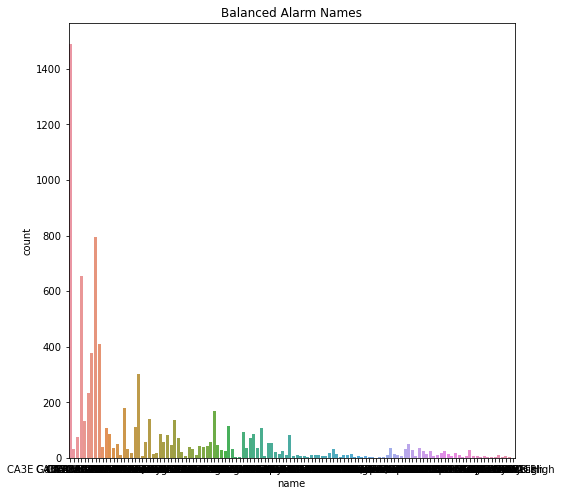

In [140]:
# Shuffle the Dataset.
shuffled_df = df_named_alarms.sample(frac=1,random_state=4)

infrequent_alarm_names = [
    'CA3 LifeSafety', 'CA8 FACP', 'CA30 General Alarm', 'CA4 FACP', 'CA3 PCW',
    'CA3E Fire', 'CA30 Process', 'CA3 CHEM', 'CA1 HVAC LOW', 'CA3 ISW',
    'Test Alarm System', 'CA1 HVAC HIHI', 'CA3E Chem', 'Free. WWTP', 'CA3 RODI - LOW',
    'CA3E PCW', 'CA4 HHW', 'CA9 HVAC', 'CA3 Fire', 'CA3E Gas - Alarm',
    'CA9 HVAC - HIGH', 'CA1 Fire', 'CA3 RODI - Low', 'CA10 - Fire', 'CA3E Gas - Instrument Fault',
    'CA3 N2 HiHi Pres', 'LoAlert', 'CA31 FACP', 'HiAlert', 'CA3 N2 Hi Pres',
    'CA3 Gas - Fault Code 1', 'CA5 FACP', 'Novate Test', 'CA10 HVAC - HIGH', 'CA1 HVAC - High',
    'CA3E Gas - Maintenance Fault', 'CA3E HVAC - FAULT', 'CA03 Process',  
    'CA1 PCW', 'CA3E CDA', 'CA3 HVAC - High',
    'CA3 Life Safety', 'CA3 RODI', 'CA6 FACP', 'CA9 PCW',    
    'CA3 Gas - Trouble', 'CA10 HVAC', 'CA3 Gas - Alarm',
     'CA4 PWR', 'CA3 PWR', 'CA3 Gas - Lo Alarm', 'CA8 - Fire',
    'CA3 N2 LoLo Pres',  'CA5 - Fire', 'CA3 Gas - Warning', 'CA3 N2 Lo Pres',
    'CA3 Gas - Hi Alarm', 'CA3E Power', 'CA4 - Fire', 'CA31 POWER', 'CA32 POWER',
    'CA3 RODI - FAULT', 'CA3E Gas - Warning', 'CA8 HVAC - HIGH', 'CA3 Gas - Fault Code 2', 'CA6 - Fire',
    'CA31 Fire', 'Inns. BR3 Air Compressor Low', 'CA3 HVAC - LOW', 'CA8 PCW', 'CA3E CDA - Alarm',
    'CA3E Chem - pH LoLo', 'CA3E PWR', 'CA1 CDA - Low', 'CA1 Cafe', 'CA3 I3 HF LS1 Leak',
    'CA30 Probes', 'CA30 PH Probes', 'Process Alarm', 'CA3E CDA - Warning', 'LoLo Alarm',
    'CA3E Chem - Low pH', 'CA1 PWR', 'CA3E CDA - AIT401 Hi', 'CA3E GAS', 'CA3 RODI - HIGH',
    'Lo Alarm', 'CA3E Gas - Maintenance AND Instrument Fault', 'CA8  HVAC', 'Secondary_Containment_Water', 'CA3 Gas - Fault Code 3',
    'CA8 CDA', 'CA04 Fire/Gas', 'CA3E Chem - pH Low', 'Inns. Water Tank LAL', 'Inns. - Power',
    'Inns. Water Tank LALL', 'CA3 Power', 'CA31 Fire/Gas', 'CA1 Cafe - High Temp', 'CA3 F2',
    'CA3E CDA - AIT401 HiHi', 'CA8 IVAC', 'CA3 - Gas', 'Free. WWTP Caustic Low', 'Inns. Water Tank LAH',
    'CA3 GEF', 'CA3 Q4 Scrubber', 'CA3 Q4 PCW', 'Free. WWTP Caustic LoLo', 'CA3E IVAC',
    'Inns. Water Tank LAHH', 'CA30 CDA - Low']
# Put all the fraud class in a separate dataset.
infrequent_alarms_df = shuffled_df[shuffled_df.name.isin(infrequent_alarm_names)]

#Randomly select 492 observations from the non-priority alarms (majority class)
frequent_alarm_names = [
    'CA1 CDA', 'Alarm', 'CA5 HVAC - Low', 'CA3 HVAC', 'CA3 PCW3',
    'CA3E Gas', 'CA3 MXLP', 'CA3E HVAC - HIGH', 'CA3E FACP',
    'CA3E Process', 'CA8 HVAC', 'Alert', 'CA4 HVAC - High',
    'CA3 FACP', 'CA4 HVAC - Low', 'CA3 Process', 'CA3E Gas - Trouble',
    'CA9 HVAC - Low', 'Off Alarm', 'CA5 HVAC', 'CA3E HVAC',
    'CA30 Chem', 'CA1 HVAC - Low', 'CA1 HVAC', 'CA3 POWER',
    'CA8 HVAC - LOW', 'CA3 Chem', 'CA9 HVAC - LOW', 'CA9 HVAC - High',
    'CA1 FACP', 'CA3 HVAC - HIGH', 'CA4 HVAC', 'CA10 FACP',
    'UserNotify', 'CA3 Gas', 'CA1 HVAC HIGH', 'CA30 pH',
    'CA5 HVAC - High', 'CA1 HVAC LOLO', 'CA3E Gas - Supervisory', 'CA3E HVAC - LOW']

frequent_alarms_df = shuffled_df[shuffled_df.name.isin(frequent_alarm_names)].sample(n=492,random_state=42)

# Concatenate both dataframes again
normalized_df = pd.concat([infrequent_alarms_df, frequent_alarms_df])

#plot the dataset after the undersampling
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8, 8))
sns.countplot('name', data=normalized_df)
plt.title('Balanced Alarm Names')
plt.show()

In [141]:
normalized_df.to_csv('ALARM_TYPE_normalized.csv')

In [142]:
# pandas count distinct values in column
normalized_df['name'].value_counts()

CA5 FACP                                       1491
CA3 HVAC - LOW                                  794
CA3E PCW                                        654
CA30 General Alarm                              409
CA10 HVAC - HIGH                                377
CA31 FACP                                       303
CA1 HVAC LOW                                    235
CA3 LifeSafety                                  181
CA3 PCW                                         167
CA3 Gas - Fault Code 1                          141
CA3E HVAC - FAULT                               135
CA1 HVAC HIHI                                   134
CA3E Gas - Alarm                                113
CA3E Fire                                       111
CA3 ISW                                         108
Test Alarm System                               106
CA3 RODI - Low                                   94
CA30 Process                                     86
CA9 HVAC - HIGH                                  86
CA3 N2 Hi Pr

In [143]:
normalized_df.head()

,alarmid,eventid,displaypath,priority,etype,name,ackby,VALUE,devicetype,deviceid,logicalinterface_id,eventtype,format,rcv_timestamp_utc,updated_utc,LEVEL_0,LEVEL_1,LEVEL_2,TAGPATH,LEVEL_3,LEVEL_4,client,LEVEL_5,LEVEL_6
70795,7326818,10e08db2-112a-4bf6-a656-4099d023b055,"TROUBLE IN :2-27 00:19:00 May 04,...",1,0,CA5 FACP,NaN,0.0,AlarmData_Type,b5804ed7-49aa-353a-a53d-fd1e27c38624,NaN,alarm,JSON,2021-08-13 08:32:26,2021-08-13 08:32:26,ca5,fire_gas,message,ca5/fire_gas/message,NaN,NaN,LAMResearch,NaN,NaN
14708,7303605,fa404314-3ecc-4d8a-a73b-8c470689ea0e,CA4 - Generator Running,4,2,CA4 PWR,NSOC,0.0,AlarmData_Type,58f1d487-2e30-3909-9ead-4da3472012a4,NaN,alarm,JSON,2021-07-26 10:39:09,2021-07-26 10:39:09,ca4,power,generator,ca4/power/generator/generator_running,generator_running,NaN,LAMResearch,NaN,NaN
14714,7331452,4a4741cb-461f-485d-b160-38e7295fc95c,CA4 - Generator Running,0,0,CA4 PWR,NaN,0.0,AlarmData_Type,58f1d487-2e30-3909-9ead-4da3472012a4,NaN,alarm,JSON,2021-08-19 06:57:07,2021-08-19 06:57:07,ca4,power,generator,ca4/power/generator/generator_running,generator_running,NaN,LAMResearch,NaN,NaN
3081,7311498,fcb234b3-abfc-4414-8574-0926bb96e4dd,VER1C - Az 2-3 Instrument Fault,0,0,CA3E Gas - Instrument Fault,NaN,0.0,AlarmData_Type,de8d39ee-7b3b-3f0b-aec4-490b197bb87e,NaN,alarm,JSON,2021-08-02 22:23:42,2021-08-02 22:23:42,ca3e,mxl,vertex,ca3e/mxl/vertex/ver1c/tier2/status/fault slot 3,ver1c,tier2,LAMResearch,status,fault slot 3
64663,7292785,d55cc1c6-9551-42b8-a1f8-baa3da7c3fd0,CA3E CHW Loop Supply Flow Low Alarm,4,0,CA3E PCW,NaN,0.0,AlarmData_Type,0e8e3f9d-1a7b-3ca5-a69e-e9e467a07bff,NaN,alarm,JSON,2021-07-17 23:40:05,2021-07-17 23:40:05,ca3e,pcw,fit_2,ca3e/pcw/fit_2/lo_alm,lo_alm,NaN,LAMResearch,NaN,NaN


In [144]:
#  Add a column importance and set all rows with default value of  3 
#  alarm_importance 
#    0 False positive  IE Alarms that happen frequently can be ignored.
#    1 Resolve < 15 minutes  ( Less than 100 have occurred in a sample of 111,553
#    2 Resolve < 1 hour,  Acknowledge by someone
#    3 Resolve < 1 day  
normalized_df['importance'] =  3

In [145]:
normalized_df[~normalized_df.name.isin(frequent_alarm_names)].head()

,alarmid,eventid,displaypath,priority,etype,name,ackby,VALUE,devicetype,deviceid,logicalinterface_id,eventtype,format,rcv_timestamp_utc,updated_utc,LEVEL_0,LEVEL_1,LEVEL_2,TAGPATH,LEVEL_3,LEVEL_4,client,LEVEL_5,LEVEL_6,importance
70795,7326818,10e08db2-112a-4bf6-a656-4099d023b055,"TROUBLE IN :2-27 00:19:00 May 04,...",1,0,CA5 FACP,NaN,0.0,AlarmData_Type,b5804ed7-49aa-353a-a53d-fd1e27c38624,NaN,alarm,JSON,2021-08-13 08:32:26,2021-08-13 08:32:26,ca5,fire_gas,message,ca5/fire_gas/message,NaN,NaN,LAMResearch,NaN,NaN,3
14708,7303605,fa404314-3ecc-4d8a-a73b-8c470689ea0e,CA4 - Generator Running,4,2,CA4 PWR,NSOC,0.0,AlarmData_Type,58f1d487-2e30-3909-9ead-4da3472012a4,NaN,alarm,JSON,2021-07-26 10:39:09,2021-07-26 10:39:09,ca4,power,generator,ca4/power/generator/generator_running,generator_running,NaN,LAMResearch,NaN,NaN,3
14714,7331452,4a4741cb-461f-485d-b160-38e7295fc95c,CA4 - Generator Running,0,0,CA4 PWR,NaN,0.0,AlarmData_Type,58f1d487-2e30-3909-9ead-4da3472012a4,NaN,alarm,JSON,2021-08-19 06:57:07,2021-08-19 06:57:07,ca4,power,generator,ca4/power/generator/generator_running,generator_running,NaN,LAMResearch,NaN,NaN,3
3081,7311498,fcb234b3-abfc-4414-8574-0926bb96e4dd,VER1C - Az 2-3 Instrument Fault,0,0,CA3E Gas - Instrument Fault,NaN,0.0,AlarmData_Type,de8d39ee-7b3b-3f0b-aec4-490b197bb87e,NaN,alarm,JSON,2021-08-02 22:23:42,2021-08-02 22:23:42,ca3e,mxl,vertex,ca3e/mxl/vertex/ver1c/tier2/status/fault slot 3,ver1c,tier2,LAMResearch,status,fault slot 3,3
64663,7292785,d55cc1c6-9551-42b8-a1f8-baa3da7c3fd0,CA3E CHW Loop Supply Flow Low Alarm,4,0,CA3E PCW,NaN,0.0,AlarmData_Type,0e8e3f9d-1a7b-3ca5-a69e-e9e467a07bff,NaN,alarm,JSON,2021-07-17 23:40:05,2021-07-17 23:40:05,ca3e,pcw,fit_2,ca3e/pcw/fit_2/lo_alm,lo_alm,NaN,LAMResearch,NaN,NaN,3


In [146]:
#  Find all rows that have frequent alarms and set to 0 for False Postives
#  Get the indices for the rows you want to change
index = normalized_df[normalized_df.name.isin(frequent_alarm_names)].index

# now use df.loc to set values only to those rows
normalized_df.loc[index,'importance'] = 0

In [147]:
# pandas count distinct values in column
normalized_df['importance'].value_counts()

3    7489
0     492
Name: importance, dtype: int64

In [148]:
normalized_df.head()

,alarmid,eventid,displaypath,priority,etype,name,ackby,VALUE,devicetype,deviceid,logicalinterface_id,eventtype,format,rcv_timestamp_utc,updated_utc,LEVEL_0,LEVEL_1,LEVEL_2,TAGPATH,LEVEL_3,LEVEL_4,client,LEVEL_5,LEVEL_6,importance
70795,7326818,10e08db2-112a-4bf6-a656-4099d023b055,"TROUBLE IN :2-27 00:19:00 May 04,...",1,0,CA5 FACP,NaN,0.0,AlarmData_Type,b5804ed7-49aa-353a-a53d-fd1e27c38624,NaN,alarm,JSON,2021-08-13 08:32:26,2021-08-13 08:32:26,ca5,fire_gas,message,ca5/fire_gas/message,NaN,NaN,LAMResearch,NaN,NaN,3
14708,7303605,fa404314-3ecc-4d8a-a73b-8c470689ea0e,CA4 - Generator Running,4,2,CA4 PWR,NSOC,0.0,AlarmData_Type,58f1d487-2e30-3909-9ead-4da3472012a4,NaN,alarm,JSON,2021-07-26 10:39:09,2021-07-26 10:39:09,ca4,power,generator,ca4/power/generator/generator_running,generator_running,NaN,LAMResearch,NaN,NaN,3
14714,7331452,4a4741cb-461f-485d-b160-38e7295fc95c,CA4 - Generator Running,0,0,CA4 PWR,NaN,0.0,AlarmData_Type,58f1d487-2e30-3909-9ead-4da3472012a4,NaN,alarm,JSON,2021-08-19 06:57:07,2021-08-19 06:57:07,ca4,power,generator,ca4/power/generator/generator_running,generator_running,NaN,LAMResearch,NaN,NaN,3
3081,7311498,fcb234b3-abfc-4414-8574-0926bb96e4dd,VER1C - Az 2-3 Instrument Fault,0,0,CA3E Gas - Instrument Fault,NaN,0.0,AlarmData_Type,de8d39ee-7b3b-3f0b-aec4-490b197bb87e,NaN,alarm,JSON,2021-08-02 22:23:42,2021-08-02 22:23:42,ca3e,mxl,vertex,ca3e/mxl/vertex/ver1c/tier2/status/fault slot 3,ver1c,tier2,LAMResearch,status,fault slot 3,3
64663,7292785,d55cc1c6-9551-42b8-a1f8-baa3da7c3fd0,CA3E CHW Loop Supply Flow Low Alarm,4,0,CA3E PCW,NaN,0.0,AlarmData_Type,0e8e3f9d-1a7b-3ca5-a69e-e9e467a07bff,NaN,alarm,JSON,2021-07-17 23:40:05,2021-07-17 23:40:05,ca3e,pcw,fit_2,ca3e/pcw/fit_2/lo_alm,lo_alm,NaN,LAMResearch,NaN,NaN,3


In [149]:
#  Find all rows that have infrequent alarms and set to 2 .
index = normalized_df[normalized_df.name.isin(infrequent_alarm_names)].index

# now use df.loc to set values only to those rows
normalized_df.loc[index, 'importance'] = 2

In [150]:
# pandas count distinct values in column
normalized_df['importance'].value_counts()

2    7489
0     492
Name: importance, dtype: int64

In [151]:
normalized_df.head()

,alarmid,eventid,displaypath,priority,etype,name,ackby,VALUE,devicetype,deviceid,logicalinterface_id,eventtype,format,rcv_timestamp_utc,updated_utc,LEVEL_0,LEVEL_1,LEVEL_2,TAGPATH,LEVEL_3,LEVEL_4,client,LEVEL_5,LEVEL_6,importance
70795,7326818,10e08db2-112a-4bf6-a656-4099d023b055,"TROUBLE IN :2-27 00:19:00 May 04,...",1,0,CA5 FACP,NaN,0.0,AlarmData_Type,b5804ed7-49aa-353a-a53d-fd1e27c38624,NaN,alarm,JSON,2021-08-13 08:32:26,2021-08-13 08:32:26,ca5,fire_gas,message,ca5/fire_gas/message,NaN,NaN,LAMResearch,NaN,NaN,2
14708,7303605,fa404314-3ecc-4d8a-a73b-8c470689ea0e,CA4 - Generator Running,4,2,CA4 PWR,NSOC,0.0,AlarmData_Type,58f1d487-2e30-3909-9ead-4da3472012a4,NaN,alarm,JSON,2021-07-26 10:39:09,2021-07-26 10:39:09,ca4,power,generator,ca4/power/generator/generator_running,generator_running,NaN,LAMResearch,NaN,NaN,2
14714,7331452,4a4741cb-461f-485d-b160-38e7295fc95c,CA4 - Generator Running,0,0,CA4 PWR,NaN,0.0,AlarmData_Type,58f1d487-2e30-3909-9ead-4da3472012a4,NaN,alarm,JSON,2021-08-19 06:57:07,2021-08-19 06:57:07,ca4,power,generator,ca4/power/generator/generator_running,generator_running,NaN,LAMResearch,NaN,NaN,2
3081,7311498,fcb234b3-abfc-4414-8574-0926bb96e4dd,VER1C - Az 2-3 Instrument Fault,0,0,CA3E Gas - Instrument Fault,NaN,0.0,AlarmData_Type,de8d39ee-7b3b-3f0b-aec4-490b197bb87e,NaN,alarm,JSON,2021-08-02 22:23:42,2021-08-02 22:23:42,ca3e,mxl,vertex,ca3e/mxl/vertex/ver1c/tier2/status/fault slot 3,ver1c,tier2,LAMResearch,status,fault slot 3,2
64663,7292785,d55cc1c6-9551-42b8-a1f8-baa3da7c3fd0,CA3E CHW Loop Supply Flow Low Alarm,4,0,CA3E PCW,NaN,0.0,AlarmData_Type,0e8e3f9d-1a7b-3ca5-a69e-e9e467a07bff,NaN,alarm,JSON,2021-07-17 23:40:05,2021-07-17 23:40:05,ca3e,pcw,fit_2,ca3e/pcw/fit_2/lo_alm,lo_alm,NaN,LAMResearch,NaN,NaN,2


In [152]:
#  Find all rows with infrequent alarms to importance with 2 that have been acknowledged by an enginer
#  Get the indices for the rows you want to change
index = normalized_df[normalized_df.ackby.notna()].index

# now use df.loc to set values only to those rows
normalized_df.loc[index,'importance'] = 1

# pandas count distinct values in column
normalized_df['importance'].value_counts()

2    5839
1    1723
0     419
Name: importance, dtype: int64

In [153]:
#  Set alarms with row using reg expression for fire.
#normalized_df[normalized_df['tagpath'].str.contains("fire")]

#  Find all rows with infrequent alarms to importance with 2 that have been acknowledged by an enginer
#  Get the indices for the rows you want to change
#index = normalized_df[~normalized_df["tagpath"].str.contains('fire')].index

# now use df.loc to set values only to those rows
#normalized_df.loc[index,'importance'] = 2

# pandas count distinct values in column
#normalized_df['importance'].value_counts()

In [154]:
# Save Alarm Dimension Data.
normalized_df.to_csv('ALARM_TYPE_normalized_trained.csv')

In [155]:
# Start here once you have normalized training data
# Import Classificatin model & SDKs
import pandas as pd
#from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

In [156]:
# Import trained normalized Alarms
training_data = pd.read_csv('ALARM_TYPE_normalized_trained.csv', index_col=0)

In [158]:
# Pick input colums to classify `importance` using   'displaypath', 'leval_0', 'leval_1', 'leval_2', 'leval_3', 'leval_4', 'leval_5', 'leval_6',
training_features = [  'ackby', 'LEVEL_0', 'LEVEL_1', 'TAGPATH', 'LEVEL_2', 'LEVEL_3', 'LEVEL_4', 'LEVEL_5', 'LEVEL_6']
training_targets = ['importance']


x = training_data[training_features].fillna("")
y = training_data[training_targets]

print ("--- features ---")
print ( x.head() )
print (x.info())
print(f"x.shape {x.shape}")

print ("--- target ---")
print (y.head())
print("y.shape")
print(y.shape)
print(f"y.shape {y.shape}")

--- features ---
      ackby LEVEL_0   LEVEL_1  \
70795           ca5  fire_gas   
14708  NSOC     ca4     power   
14714           ca4     power   
3081           ca3e       mxl   
64663          ca3e       pcw   

                                               TAGPATH    LEVEL_2  \
70795                             ca5/fire_gas/message    message   
14708            ca4/power/generator/generator_running  generator   
14714            ca4/power/generator/generator_running  generator   
3081   ca3e/mxl/vertex/ver1c/tier2/status/fault slot 3     vertex   
64663                            ca3e/pcw/fit_2/lo_alm      fit_2   

                 LEVEL_3 LEVEL_4 LEVEL_5       LEVEL_6  
70795                                                   
14708  generator_running                                
14714  generator_running                                
3081               ver1c   tier2  status  fault slot 3  
64663             lo_alm                                
<class 'pandas.core.frame.D

In [159]:
#  Requires installing brew install libomp
#from xgboost import XGBClassifier
#import xgboost as xgb
from sklearn.metrics import accuracy_score

# Build a model for each Entity in the EntityType
entity_type = 'LAMUCS1_ALARM_TYPE'

entity_type_id = 12239
entity_name = 'CA3 HVAC'



In [160]:
# Pick input colums to classify `importance` using   'displaypath', 'leval_0', 'leval_1', 'leval_2', 'leval_3', 'leval_4', 'leval_5', 'leval_6',
training_features = [  'ackby', 'LEVEL_0', 'LEVEL_1', 'TAGPATH', 'LEVEL_2', 'LEVEL_3', 'LEVEL_4', 'LEVEL_5', 'LEVEL_6']
training_targets = ['importance']


x = training_data[training_features].fillna("")
y = training_data[training_targets]

print ("--- features ---")
print ( x.head() )
print (x.info())
print(f"x.shape {x.shape}")

print ("--- target ---")
print (y.head())
print("y.shape")
print(y.shape)
print(f"y.shape {y.shape}")

--- features ---
      ackby LEVEL_0   LEVEL_1  \
70795           ca5  fire_gas   
14708  NSOC     ca4     power   
14714           ca4     power   
3081           ca3e       mxl   
64663          ca3e       pcw   

                                               TAGPATH    LEVEL_2  \
70795                             ca5/fire_gas/message    message   
14708            ca4/power/generator/generator_running  generator   
14714            ca4/power/generator/generator_running  generator   
3081   ca3e/mxl/vertex/ver1c/tier2/status/fault slot 3     vertex   
64663                            ca3e/pcw/fit_2/lo_alm      fit_2   

                 LEVEL_3 LEVEL_4 LEVEL_5       LEVEL_6  
70795                                                   
14708  generator_running                                
14714  generator_running                                
3081               ver1c   tier2  status  fault slot 3  
64663             lo_alm                                
<class 'pandas.core.frame.D

In [161]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)
X_train.head()

,ackby,LEVEL_0,LEVEL_1,TAGPATH,LEVEL_2,LEVEL_3,LEVEL_4,LEVEL_5,LEVEL_6
70562,,ca5,fire_gas,ca5/fire_gas/message,message,,,,
35774,,ca30,awn,ca30/awn/awn_failure_alarm,awn_failure_alarm,,,,
3486,,ca3e,mxl,ca3e/mxl/gacp/loop008/loop008_6/8,gacp,loop008,loop008_6,8,
70476,,ca5,fire_gas,ca5/fire_gas/message,message,,,,
71175,,ca5,fire_gas,ca5/fire_gas/message,message,,,,


In [162]:
X_train.dtypes, y_train.dtypes

(ackby      object
 LEVEL_0    object
 LEVEL_1    object
 TAGPATH    object
 LEVEL_2    object
 LEVEL_3    object
 LEVEL_4    object
 LEVEL_5    object
 LEVEL_6    object
 dtype: object,
 importance    int64
 dtype: object)

In [163]:
X_test.head()

,ackby,LEVEL_0,LEVEL_1,TAGPATH,LEVEL_2,LEVEL_3,LEVEL_4,LEVEL_5,LEVEL_6
50638,,ca5,fire_gas,ca5/fire_gas/fire_alm_trouble,fire_alm_trouble,,,,
67176,Shasta Douglas,ca3,mxl,ca3/mxl/vertex/ver3/tier1/status/fault slot 1,vertex,ver3,tier1,status,fault slot 1
61471,NSOC,ca10,hvac,ca10/hvac/ac/ac12/alarm: outdoor air damper no...,ac,ac12,alarm: outdoor air damper not modulating,,
7679,,ca3,power,ca3/power/ca_03_cdl1a_1k/powermonitor_commstatus,ca_03_cdl1a_1k,powermonitor_commstatus,,,
72328,Shasta Douglas,ca8,cda,ca8/cda/dryer2/is connected,dryer2,is connected,,,


In [168]:
# one-hot encode the categorical features
categorical_features = ['ackby', 'LEVEL_0', 'LEVEL_1', 'TAGPATH', 'LEVEL_2', 'LEVEL_3', 'LEVEL_4', 'LEVEL_5', 'LEVEL_6']

categorical_preprocessor = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combine all feature preprocessing
preprocessor = ColumnTransformer([
    ('cat', categorical_preprocessor, categorical_features)],
    remainder='passthrough')

In [169]:
training_pipeline = Pipeline([('preprocessor', preprocessor),
                              ('model', LGBMClassifier())])

In [170]:
#To perform hyperparameter tuining RUN THIS CELL
param_dist = {
          #'model__n_estimators': [20, 50, 100, 500], 
          #'model__learning_rate': [10, 1, 0.1, 0.01, 0.001], 
          'model__n_estimators' : [20, 50, 100],
          'model__learning_rate': [10, 1, 0.1]
          #'model__tree_method': ['auto', 'hist', 'exact'],   # Only valid after version 0.72. 
}
training_pipeline = RandomizedSearchCV(training_pipeline, param_distributions=param_dist, n_iter=50)

In [171]:
training_pipeline.fit(X_train, y_train)

/home/markus/.local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 9 is smaller than n_iter=50. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/markus/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/markus/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/markus/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using rav

/home/markus/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/markus/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/markus/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/markus/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ),

RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('cat',
                                                                               Pipeline(steps=[('encoder',
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               ['ackby',
                                                                                'LEVEL_0',
                                                                                'LEVEL_1',
                                                                                'TAGPATH',
                                                                                'LEVEL_2',
                                                                

In [172]:
# See what format X_test is

X_test.head()

,ackby,LEVEL_0,LEVEL_1,TAGPATH,LEVEL_2,LEVEL_3,LEVEL_4,LEVEL_5,LEVEL_6
50638,,ca5,fire_gas,ca5/fire_gas/fire_alm_trouble,fire_alm_trouble,,,,
67176,Shasta Douglas,ca3,mxl,ca3/mxl/vertex/ver3/tier1/status/fault slot 1,vertex,ver3,tier1,status,fault slot 1
61471,NSOC,ca10,hvac,ca10/hvac/ac/ac12/alarm: outdoor air damper no...,ac,ac12,alarm: outdoor air damper not modulating,,
7679,,ca3,power,ca3/power/ca_03_cdl1a_1k/powermonitor_commstatus,ca_03_cdl1a_1k,powermonitor_commstatus,,,
72328,Shasta Douglas,ca8,cda,ca8/cda/dryer2/is connected,dryer2,is connected,,,


In [173]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1597 entries, 50638 to 35824
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   ackby    1597 non-null   object
 1   LEVEL_0  1597 non-null   object
 2   LEVEL_1  1597 non-null   object
 3   TAGPATH  1597 non-null   object
 4   LEVEL_2  1597 non-null   object
 5   LEVEL_3  1597 non-null   object
 6   LEVEL_4  1597 non-null   object
 7   LEVEL_5  1597 non-null   object
 8   LEVEL_6  1597 non-null   object
dtypes: object(9)
memory usage: 124.8+ KB


In [174]:
# extract the training set predictions
predictions = training_pipeline.predict(X_test)

In [175]:
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 99.50%


In [176]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96        93
           1       1.00      1.00      1.00       331
           2       1.00      1.00      1.00      1173

    accuracy                           0.99      1597
   macro avg       0.99      0.98      0.98      1597
weighted avg       0.99      0.99      0.99      1597



In [177]:
# save the model to disk
import pickle
model_name = 'alarms_classification_101_model.mod'
model_file_path = model_name
pickle.dump(training_pipeline, open(model_file_path, 'wb'))

# Load the model from disk
model = pickle.load(open(model_file_path, 'rb'))
print(model)

# Test prediction on  a single row prediction
# alarmid eventid                                      displaypath                           priority etype name    ackby VALUE devicetype     deviceid                             logicalinterface_id eventtype format rcv_timestamp_utc                 updated_utc level_0 level_1 level_2           tagpath                              level_3 level_4 client      level_5 level_6 importance
# 109317  7148531	3d54c77b-9a19-4aab-a523-014734fb4e5c CA3/ISW: FT1302 Recirc Flow Low Alarm 3        0     CA3 ISW NaN   0     AlarmData_Type 5d6b5071-e6b8-3d4a-ac0d-60c77b3a1c4a NaN                 alarm     JSON   11/05/2021 14:13	11/05/2021 14:13 NaN         ca3     isw     fit1302_recircflw ca3/isw/fit1302_recircflw/alm/lo_alm alm     lo_alm  LAMResearch NaN     Nan     3


# Power should be 19.452
#row = [['ca3', 'isw', 'ca3/isw/pdit1305/alm/hi_alm', 'pdit1305', 'alm', 'hi_alm', '', '']]
row = X_test.head()

yhat = model.predict(row)
print(yhat)

RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('cat',
                                                                               Pipeline(steps=[('encoder',
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               ['ackby',
                                                                                'LEVEL_0',
                                                                                'LEVEL_1',
                                                                                'TAGPATH',
                                                                                'LEVEL_2',
                                                                

In [178]:
X_test.head()

,ackby,LEVEL_0,LEVEL_1,TAGPATH,LEVEL_2,LEVEL_3,LEVEL_4,LEVEL_5,LEVEL_6
50638,,ca5,fire_gas,ca5/fire_gas/fire_alm_trouble,fire_alm_trouble,,,,
67176,Shasta Douglas,ca3,mxl,ca3/mxl/vertex/ver3/tier1/status/fault slot 1,vertex,ver3,tier1,status,fault slot 1
61471,NSOC,ca10,hvac,ca10/hvac/ac/ac12/alarm: outdoor air damper no...,ac,ac12,alarm: outdoor air damper not modulating,,
7679,,ca3,power,ca3/power/ca_03_cdl1a_1k/powermonitor_commstatus,ca_03_cdl1a_1k,powermonitor_commstatus,,,
72328,Shasta Douglas,ca8,cda,ca8/cda/dryer2/is connected,dryer2,is connected,,,


In [179]:
# Get Connection to DB to save and retreive models
from iotfunctions.db import Database
import json
import pickle
credentials = {}
credential_file = 'credentials_as_beta2.json'
model_name = 'alarms_classification_101_model.mod'
model_file_path = model_name
entity_type_id = 22858
print(entity_type_id)

# Load the model from disk
model = pickle.load(open(model_file_path, 'rb'))
print(model)

with open(credential_file, encoding='utf-8') as F:
    credentials = json.loads(F.read())
    
db_ctp = Database(credentials=credentials, entity_type_id=entity_type_id )

print (db_ctp.tenant_id)


# Store the model with Datetimestamp and vector to DB db_ctp
from datetime import datetime
try:
    feature_vector = ['ackby', 'level_0', 'level_1', 'tagpath', 'level_2', 'level_3', 'level_4', 'level_5', 'level_6']
    model_dict  = {
    'model': model,
    'feature_vector': feature_vector,
    'timesstamp' : datetime.now().strftime("%Y%m%d%H%M%S")
    }
    print("model_name")
    print(model_name)
    print("model_dict")
    print(model_dict)
    db_ctp.model_store.store_model(model_name, model_dict) 
    print("Saved Model %s" %model_name)
except Exception as e:
    print('Model store failed with ' + str(e))
    pass


# Retrieve the model from db
try:
    model_dict = db_ctp.model_store.retrieve_model(model_name)
    print('load model')
    monitor_model = model_dict['model']
    print(monitor_model)
    feature_vector = model_dict['feature_vector']
    print(feature_vector)
    feature_vector = model_dict['timesstamp']
    print(feature_vector)
except Exception as e:
    print('Model retrieval failed with ' + str(e))
    pass

22858
RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('cat',
                                                                               Pipeline(steps=[('encoder',
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               ['ackby',
                                                                                'LEVEL_0',
                                                                                'LEVEL_1',
                                                                                'TAGPATH',
                                                                                'LEVEL_2',
                                                          

In [181]:
# Test prediction on  a single row prediction
import pandas as pd

# Classification Prediction should be 2
# lst = [['', 'ca3', 'isw', 'ca3/isw/pdit1305/alm/hi_alm', 'pdit1305', 'alm', 'hi_alm', '', '']]

# Classification Prediction should be 2 but gives 1
#lst = [['NSOC', 'CA3', 'CDA', 'CA3/CDA/CDA_Pressure', 'CDA_Pressure', '', '', '', '']]

# Classification Prediction should be 1 but gives 2
#lst = [['', 'CA3', 'N2_BAK', 'CA3/N2_BAK/N2Supply/NetFlowCFM', 'N2Supply', 'NetFlowCFM', '', '', '']]

# Classification Prediction should be 1 but gives 2
lst = [['', 'CA3', 'MXL', 'CA3/MXL/Vertex/VER4/Tier1/Status/Fault Slot 3', 'Vertex', 'VER4', 'Tier1', 'Status', 'Fault Slot 3']]

feature_vector = ['ackby', 'LEVEL_0', 'LEVEL_1', 'TAGPATH', 'LEVEL_2', 'LEVEL_3', 'LEVEL_4', 'LEVEL_5', 'LEVEL_6']


tf = pd.DataFrame(lst, columns = feature_vector, dtype = str)
tf.info()

yhat = monitor_model.predict(tf)
print(yhat)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   ackby    1 non-null      object
 1   LEVEL_0  1 non-null      object
 2   LEVEL_1  1 non-null      object
 3   TAGPATH  1 non-null      object
 4   LEVEL_2  1 non-null      object
 5   LEVEL_3  1 non-null      object
 6   LEVEL_4  1 non-null      object
 7   LEVEL_5  1 non-null      object
 8   LEVEL_6  1 non-null      object
dtypes: object(9)
memory usage: 200.0+ bytes
[2]


In [182]:
model

RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('cat',
                                                                               Pipeline(steps=[('encoder',
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               ['ackby',
                                                                                'LEVEL_0',
                                                                                'LEVEL_1',
                                                                                'TAGPATH',
                                                                                'LEVEL_2',
                                                                